In [1]:
import numpy as np
import tensorflow as tf

import pandas as pd
from scipy.stats import norm

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from nn_models import *
import pickle

from IPython.display import HTML

from utils import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
__date__ = '2017-08-04'

Using TensorFlow backend.


# BUILD CONDITIONAL VAE where conditional inputs are Time, Day, and Summary of past events!

In [5]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

batch_size = 100
original_dim = 15
latent_dim = 2
m = batch_size # batch size
n_z = 2 # latent space size
conv_intermediate = 32
intermediate_dim = 10
decoder_dim = intermediate_dim # dim of decoder hidden layer
decoder_out_dim = original_dim # dim of decoder output layer

n_x = original_dim
n_epoch = 100
n_d = 7
window_size=6

X = Input(shape=(n_x,), name='Input')
previous_X = Input(shape=(window_size,n_x), name='Day')

filter_length=3
nb_input_series=original_dim
nb_outputs=latent_dim
nb_filter=16

conv1 = Conv1D(name='Conv1', 
               filters=nb_filter, 
               kernel_size=filter_length, 
               activation='elu', 
               input_shape=(window_size, nb_input_series)
              )(previous_X)

flat1 = Flatten(name='Flatten')(conv1)
dense1 = Dense(conv_intermediate, activation='relu', name='Hidden_dense')(flat1)
summary_prev = Dense(original_dim, activation='relu',name='Dense_Out2')(dense1)   

inputs = Concatenate()([X, summary_prev])
encoder_hidden = Dense(15, activation='relu')(inputs)
mu = Dense(n_z, activation='linear', name='mu')(encoder_hidden)
l_sigma = Dense(original_dim, activation='linear', name='l_sigma')(encoder_hidden)


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ), name='Sampling')([mu, l_sigma])

zc = Concatenate()([z, summary_prev])
decoder_hidden = Dense(decoder_dim, activation=activ, name='Decoder_H')
decoder_out = Dense(decoder_out_dim, activation='linear', name='Output')
d_h = decoder_hidden(zc)
outputs = decoder_out(d_h)

def vae_loss(y_true, y_pred):
    recon = original_dim * metrics.mse(y_pred, y_true)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return original_dim * metrics.mse(y_pred, y_true)

# build a model to project inputs on the latent space


d_in = Input(shape=(n_z+original_dim,))

vae = Model([X, previous_X], outputs)
encoder = Model([X, previous_X], mu)
generator = Model(d_in, d_out)

vae.compile(optimizer=optim,
    loss=vae_loss,
    metrics = [KL_loss, recon_loss])
print(vae.summary())

TypeError: Expected int32, got list containing Tensors of type '_Message' instead.

In [9]:
window_size = 6
filter_length=3
nb_filter=128
batch_size = 100
data_ = make_clean_data(window_size, batch_size,multiplier=1)

time_percentage=0.9
time_spent = data_['dataset'].sum(axis=0)/data_['dataset'].sum()*100

/Users/asturkmani/Desktop/Thesis/utils.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['timestamp'] = pd.to_datetime(df['Date'])


(41178, 6, 1) (41178,) (41178, 6, 1) (41178,)


In [10]:
original_dim = data_['x_train_c'].shape[-1]

time_dim = data_['time']
days_dim = data_['days']
latent_dim = 2
intermediate_dim = 10
epochs = 100

In [11]:
vae, encoder, generator = build_vae(original_dim,
              batch_size = batch_size,
              latent_dim = 2,
              intermediate_dim = 10,
              activ='relu',
              optim=Adam(lr=0.0005),
              epsilon_std=1.)

In [12]:
# SVG(model_to_dot(vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [13]:
vae_hist = vae.fit(data_['y_train_c'], 
                   data_['y_train_c'],
                   verbose = 0,
                   shuffle=False,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data = (
                       data_['y_test_c'],
                       data_['y_test_c']),
                   callbacks = [
                       EarlyStopping(patience = 5),
                       ]
                  )

In [37]:
y_encoded = encoder.predict(data_['yc'])*1e3
y_train_encoded = encoder.predict(data_['y_train_c'])*1e3
y_test_encoded = encoder.predict(data_['y_test_c'])*1e3
y_test_encoded

array([[ -1.06004496e+01,  -5.50576970e-02],
       [ -3.56227922e+00,   2.55234003e+00],
       [ -9.67853703e-03,  -1.47561514e+00],
       ..., 
       [ -1.75009787e+00,  -1.33870640e+01],
       [ -1.75009787e+00,  -1.33870640e+01],
       [ -1.75009787e+00,  -1.33870640e+01]], dtype=float32)

In [38]:
X = list()
X_train = list()
X_test = list()
for i in range(6):
    X.append(encoder.predict(data_['Xc'][:,i,:])*1e3)
    X_train.append(encoder.predict(data_['x_train_c'][:,i,:])*1e3)
    X_test.append(encoder.predict(data_['x_test_c'][:,i,:])*1e3)
X = np.asarray(X)
x_encoded = X.reshape(X.shape[1], X.shape[0], X.shape[2])

X_train = np.asarray(X_train)
x_train_encoded = X_train.reshape(X_train.shape[1], X_train.shape[0], X_train.shape[2])

X_test = np.asarray(X_test)
x_test_encoded = X_test.reshape(X_test.shape[1], X_test.shape[0], X_test.shape[2])

print(x_encoded.shape, x_train_encoded.shape, x_test_encoded.shape)

(18200, 6, 2) (14600, 6, 2) (3600, 6, 2)


In [42]:
window_size=6
filter_length=3
original_dim = data_['x_train_c'].shape[-1]
nb_input_series=original_dim
nb_outputs=latent_dim
nb_filter=16

inputs = Input(shape=(window_size, nb_outputs), name='Input')
conv1 = Conv1D(name='Conv1', 
               filters=nb_filter, 
               kernel_size=filter_length, 
               activation='elu', 
               input_shape=(window_size, nb_input_series)
              )(inputs)

flat1 = Flatten(name='Flatten')(conv1)
output = Dense(nb_outputs, activation='relu',name='Dense_Out2')(flat1)     # For binary classification, change the activation to 'sigmoid'
 
generator.trainable = False
outputs = generator(output)
conv_encoder = Model(inputs,flat1)
conv_model = Model(inputs,outputs)
conv_model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
print(conv_model.summary())
# To perform (binary) classification instead:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
# SVG(model_to_dot(conv_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 6, 2)              0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 4, 16)             112       
_________________________________________________________________
Flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
Dense_Out2 (Dense)           (None, 2)                 130       
_________________________________________________________________
model_5 (Model)              (None, 15)                195       
Total params: 437.0
Trainable params: 437.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [43]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.000001, verbose=0)
conv_model_data = conv_model.fit(
    x_train_encoded, 
    data_['y_train_c'], 
    verbose=2, 
    epochs=1000, 
    batch_size=64, 
    validation_data=(x_test_encoded, data_['y_test_c']), 
    callbacks=[reduce_lr,early_stop])

Train on 14600 samples, validate on 3600 samples
Epoch 1/1000
1s - loss: 0.0238 - mean_absolute_error: 0.0666 - val_loss: 0.0312 - val_mean_absolute_error: 0.0776
Epoch 2/1000
0s - loss: 0.0238 - mean_absolute_error: 0.0666 - val_loss: 0.0312 - val_mean_absolute_error: 0.0776
Epoch 3/1000
0s - loss: 0.0238 - mean_absolute_error: 0.0666 - val_loss: 0.0312 - val_mean_absolute_error: 0.0776
Epoch 4/1000
0s - loss: 0.0238 - mean_absolute_error: 0.0666 - val_loss: 0.0312 - val_mean_absolute_error: 0.0776
Epoch 5/1000
0s - loss: 0.0238 - mean_absolute_error: 0.0666 - val_loss: 0.0312 - val_mean_absolute_error: 0.0776
Epoch 6/1000
0s - loss: 0.0238 - mean_absolute_error: 0.0666 - val_loss: 0.0312 - val_mean_absolute_error: 0.0776
Epoch 7/1000
0s - loss: 0.0238 - mean_absolute_error: 0.0666 - val_loss: 0.0312 - val_mean_absolute_error: 0.0776


In [44]:
y_test_pred = conv_model.predict(x_test_encoded)
y_test_pred

array([[ 0.12362029,  0.08971555,  0.00652373, ...,  0.00668288,
         0.01154327,  0.03645849],
       [ 0.12362029,  0.08971555,  0.00652373, ...,  0.00668288,
         0.01154327,  0.03645849],
       [ 0.12362029,  0.08971555,  0.00652373, ...,  0.00668288,
         0.01154327,  0.03645849],
       ..., 
       [ 0.12362029,  0.08971555,  0.00652373, ...,  0.00668288,
         0.01154327,  0.03645849],
       [ 0.12362029,  0.08971555,  0.00652373, ...,  0.00668288,
         0.01154327,  0.03645849],
       [ 0.12680992,  0.08694033,  0.00422607, ...,  0.00894357,
         0.01058084,  0.03413412]], dtype=float32)

In [9]:
c_vae, c_encoder, c_generator =  buid_cvae(original_dim,
              batch_size = 20,
              latent_dim = 2,
              intermediate_dim = 10,
              activ='relu',
              optim=Adam(lr=0.0005),
              epsilon_std=1.,
              time_dim=24,
              day_dim=7)

In [10]:
print(c_vae.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 15)            0                                            
____________________________________________________________________________________________________
Day (InputLayer)                 (None, 7)             0                                            
____________________________________________________________________________________________________
Time (InputLayer)                (None, 24)            0                                            
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 46)            0           Input[0][0]                      
                                                                   Day[0][0]               

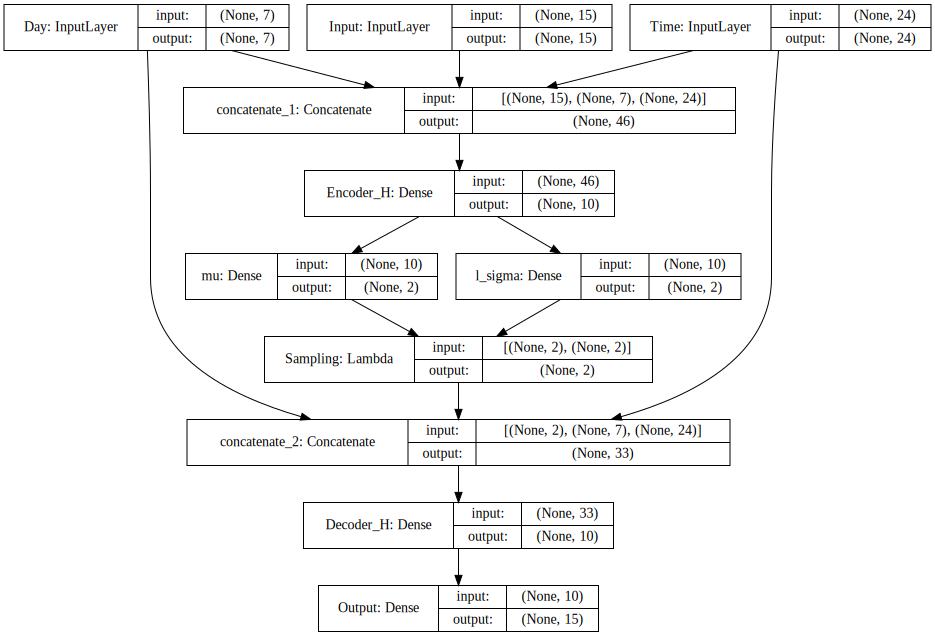

In [11]:
SVG(model_to_dot(c_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [14]:
# compile and fit
c_vae_hist = c_vae.fit([data_['y_train_c'], to_categorical(data_['y_train_d']), to_categorical(data_['y_train_t'])], 
                            data_['y_train_c'], 
                            verbose = 0, 
                            shuffle=False,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data = (
                                [data_['y_test_c'], to_categorical(data_['y_test_d']),to_categorical(data_['y_test_t'])], 
                                data_['y_test_c']),
                            callbacks = [EarlyStopping(patience = 5),
                                         TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",
                                                              leave_outer=True,
                                                              leave_inner=True)])

In [17]:
z_train = c_encoder.predict([data_['yc'], to_categorical(data_['yd']), to_categorical(data_['yt'])])
c_encoding = np.asarray(z_train)
print(c_encoding.shape)

(18280, 2)


In [18]:
x = c_encoding[:,0]
y = c_encoding[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='C_d_VAE-Data')

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

In [10]:
window_size=6
filter_length=3
nb_input_series=original_dim
nb_outputs=original_dim
nb_filter=96

inputs = Input(shape=(window_size, original_dim), name='Input')
conv1 = Conv1D(name='Conv1', 
               filters=nb_filter, 
               kernel_size=filter_length, 
               activation='elu', 
               input_shape=(window_size, nb_input_series)
              )(inputs)

flat1 = Flatten(name='Flatten')(conv1)
output = Dense(nb_outputs, activation='linear',name='Dense_Out2')(flat1)     # For binary classification, change the activation to 'sigmoid'
 
conv_encoder = Model(inputs,flat1)
conv_model = Model(inputs,output)
conv_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
print(conv_model.summary())
# To perform (binary) classification instead:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 6, 15)             0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 4, 96)             4416      
_________________________________________________________________
Flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
Dense_Out2 (Dense)           (None, 15)                5775      
Total params: 10,191
Trainable params: 10,191
Non-trainable params: 0
_________________________________________________________________
None


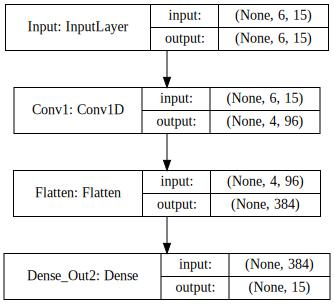

In [11]:
SVG(model_to_dot(conv_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)
conv_model_data = conv_model.fit(data_['x_train_c'], data_['y_train_c'], verbose=1, epochs=1000, batch_size=128, validation_data=(data_['x_test_c'], data_['y_test_c']), callbacks=[reduce_lr,early_stop])



Train on 14620 samples, validate on 3640 samples
Epoch 1/1000
14620/14620 [==============================] - 0s - loss: 0.0166 - mean_absolute_error: 0.0607 - val_loss: 0.0152 - val_mean_absolute_error: 0.0587
Epoch 2/1000
14620/14620 [==============================] - 0s - loss: 0.0126 - mean_absolute_error: 0.0466 - val_loss: 0.0135 - val_mean_absolute_error: 0.0520
Epoch 3/1000
14620/14620 [==============================] - 0s - loss: 0.0123 - mean_absolute_error: 0.0446 - val_loss: 0.0133 - val_mean_absolute_error: 0.0514
Epoch 4/1000
14620/14620 [==============================] - 0s - loss: 0.0122 - mean_absolute_error: 0.0439 - val_loss: 0.0135 - val_mean_absolute_error: 0.0522
Epoch 5/1000
14620/14620 [==============================] - 0s - loss: 0.0122 - mean_absolute_error: 0.0439 - val_loss: 0.0127 - val_mean_absolute_error: 0.0491
Epoch 6/1000
14620/14620 [==============================] - 0s - loss: 0.0122 - mean_absolute_error: 0.0438 - val_loss: 0.0132 - val_mean_absolute

In [13]:
x_train_encoded_conv = conv_encoder.predict(data_['x_train_c'])
x_test_encoded_conv = conv_encoder.predict(data_['x_test_c'])

In [14]:
print(x_train_encoded_conv.shape)
print(x_test_encoded_conv.shape)
x_encoded = np.concatenate((x_train_encoded_conv,x_test_encoded_conv),axis=0)
print(x_encoded.shape)

(14620, 384)
(3640, 384)
(18260, 384)


In [15]:
encoder_vae_conv,vae_conv = build_vae(original_dim = x_encoded.shape[-1],
                        latent_dim = 2,
                        intermediate_dim = 128
                       )

ValueError: too many values to unpack (expected 2)

In [ ]:
SVG(model_to_dot(vae_conv, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.000001, verbose=0)
vae_conv.compile(optimizer=RMSprop(lr=0.01), loss=None)
vae_conv.fit(x_train_encoded_conv,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_encoded_conv,x_test_encoded_conv),
       callbacks=[early_stop,reduce_lr])

In [21]:
bupu = cl.scales['6']['div']['RdBu']
# bupu = cl.interp( bupu, 30 )
HTML( cl.to_html( bupu ) )

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_encoded_vae = encoder_vae_conv.predict(x_encoded, batch_size=batch_size)

In [ ]:
x_encoded_vae[1200]

In [ ]:
gmm_scaled = GaussianMixture(n_components = 7, covariance_type='tied',random_state=24)
gmm_scaled.fit(x_encoded_vae)
gmm_scaled_labels = gmm_scaled.predict(x_encoded_vae)


In [ ]:
inertia = np.zeros(9)
for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x_encoded_vae)
    inertia[i-2] = kmeans.inertia_
    
trace = go.Scatter(x=[i for i in range(0,9)], y=inertia, mode='markers')
data= [trace]
py.iplot(data, filename='K-Means inerta')

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(x_encoded_vae)

In [ ]:
# c = [bupu[x] for x in gmm_scaled_labels] #[bupu[x] for x in data_['time_categorical']]
c = [bupu[x] for x in kmeans.labels_]
x = x_encoded_vae[:,0]
y = x_encoded_vae[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in y_labels]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color=c,opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='MNIST')

# LSTM

In [ ]:
inputs = Input(shape=(window_size, original_dim), name='Inputs')
# inputs_masked = Masking(mask_value=0., name='Masking')(inputs)
encoded = GRU(32, name='GRU1', activation='linear')(inputs)
output = Dense(original_dim, activation='linear')(encoded)

rnn_encoder = Model(inputs, encoded)
rnn_model = Model(inputs, output)

rnn_model.compile(loss='mse', metrics=['mae'], optimizer='rmsprop')
print(rnn_model.summary())

In [ ]:
SVG(model_to_dot(rnn_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)
rnn_model_data = rnn_model.fit(data_['x_train_c'], data_['y_train_c'], verbose=1, epochs=1000, batch_size=128, validation_data=(data_['x_test_c'], data_['y_test_c']), callbacks=[reduce_lr,early_stop])

In [ ]:
x_train_encoded_rnn = rnn_encoder.predict(data_['x_train_c'])
x_test_encoded_rnn = rnn_encoder.predict(data_['x_test_c'])

In [ ]:
print(x_train_encoded_rnn.shape)
print(x_test_encoded_rnn.shape)
x_encoded_rnn = np.concatenate((x_train_encoded_rnn,x_test_encoded_rnn),axis=0)
print(x_encoded_rnn.shape)

In [ ]:
m = 20 # batch size
n_z = 2 # latent space size
encoder_dim1 = 10 # dim of encoder hidden layer
decoder_dim = 10 # dim of decoder hidden layer
decoder_out_dim = len(data_['popular_apps']) # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.0005)


n_x = x_encoded_rnn.shape[1]
# n_y = y_train.shape[1]


n_epoch = 100
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

In [ ]:
X = Input(shape=(n_x,), name='Input')
# activity_regularizer = 'l2',
encoder_h = Dense(encoder_dim1, activation=activ,  name='Encoder_H')(X)
mu = Dense(n_z, activation='linear', name='mu')(encoder_h)
l_sigma = Dense(n_z, activation='linear', name='l_sigma')(encoder_h)


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ), name='Sampling')([mu, l_sigma])

decoder_hidden = Dense(decoder_dim, activation=activ, name='Decoder_H')
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name='Output')
h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return(K.sum(K.binary_crossentropy(y_pred, y_true), axis=1))

# build a model to project inputs on the latent space
vae_rnn = Model(X, outputs)
vae_rnn_encoder = Model(X, mu)
print(vae.summary())

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1, min_lr=0.000001, verbose=0)

vae_rnn.compile(optimizer=RMSprop(lr=0.001), loss=vae_loss, metrics=[KL_loss, recon_loss])
vae_rnn.fit(x_train_encoded_rnn,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_encoded_rnn,x_test_encoded_rnn),
       callbacks=[early_stop,reduce_lr])

In [ ]:
xrnn_encoded_vae = encoder_vae_rnn.predict(x_encoded_rnn, batch_size=batch_size)
print(xrnn_encoded_vae.shape)

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(xrnn_encoded_vae)

# Fit a Dirichlet process Gaussian mixture using five components
gmm = GaussianMixture(n_components=6, 
                      covariance_type='tied').fit(xrnn_encoded_vae)
gmm_labels = gmm.predict(xrnn_encoded_vae)

In [ ]:
c = [bupu[x] for x in gmm_labels]
# c = [bupu[x] for x in gmm_scaled_labels] #[bupu[x] for x in data_['time_categorical']]
# c = [bupu[x] for x in kmeans.labels_]
x = xrnn_encoded_vae[:,0]
y = xrnn_encoded_vae[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in y_labels]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color=c,opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='MNIST')

# Conv1D + VAE

In [ ]:
'''
    (None, window_size, original_dim) -> Conv1D -> (None, 384)
    (None, 384) -> Dense -> (None, 15)
    (None, 15) -> VAE Encoder -> (None, 2) -> VAE Decoder (None,15)
    loss = KL(Encoded, Standard Normal) + Reconstruction(Decoded, Dense_out) + MAE(Decoded, Y_True)

'''
epochs = 50

window_size=6
filter_length=3
nb_input_series=original_dim
nb_outputs=original_dim
nb_filter=96

batch_size = 20
latent_dim = 2
dense1 = 15
intermediate_dim = 10
epsilon_std = 1.0

inputs = Input(shape=(window_size, original_dim), name='Input')
# labels = Input(shape=(original_dim,), name='Labels')

conv1 = Conv1D(name='Conv1', 
               filters=nb_filter, 
               kernel_size=filter_length, 
               activation='relu', 
               input_shape=(window_size, nb_input_series)
              )(inputs)

flat1 = Flatten(name='Conv_output')(conv1)
#output1
conv_output = Dense(nb_outputs, activation='linear',name='Pre_Output')(flat1)



# x = Input(batch_shape=(batch_size, original_dim))

#Encoder
h = Dense(intermediate_dim, activation='elu', name='Encoder_Int1')(conv_output)
z_mean = Dense(latent_dim, activation='elu', name='Z_Mean')(h)
z_log_var = Dense(latent_dim, activation='elu', name='Z_Log_Var')(h)



# Sample
z = Lambda(sampling, name='Sampling')([z_mean, z_log_var])

# Reconstruction Decoder
decoder_h = Dense(intermediate_dim, activation='elu', name='Decoder_Int1')
decoder_mean = Dense(nb_outputs, activation='elu', name='Decoder_Out_Reconstruction')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Prediction Decoder
# decoder_h = Dense(original_dim, activation='elu', name='Decoder_Int1')
# prediction_mean = Dense(original_dim, activation='elu', name='Decoder_Out_Prediction')
# # h_decoded = decoder_h(h_decoded)
# output = prediction_mean(z)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

        return 0.2*K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([conv_output, x_decoded_mean])
    
# encoder = Model(inputs,z_mean)
cnn_vae = Model(inputs, [x_decoded_mean, y])


def pred_loss(y_true, y_pred):
    pred_loss = original_dim*metrics.mse(y_true, y_pred)
    return 0.8*K.mean(pred_loss)

    
cnn_vae.compile(optimizer=RMSprop(lr=0.01), loss=[pred_loss, None], metrics=['mae'])
    
# encoder_conv = Model(inputs, pre_output)
# vae_encoder = Model(inputs, z_mean)
# upper_bound = Model(inputs, x_decoded_mean_upper)
# lower_bound = Model(inputs, x_decoded_mean_lower)
print(cnn_vae.summary())

In [ ]:
SVG(model_to_dot(cnn_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.000001, verbose=0)

cnn_vae.fit(x=data_['x_train_c'], y=data_['y_train_c'],
             verbose=1,
             epochs=300,
             batch_size=20,
            validation_data=(data_['x_test_c'],data_['y_test_c']),
           callbacks=[early_stop,reduce_lr]
            )

In [ ]:
np.round(x_prediction[0][2010]*300)

In [ ]:
np.round(data_['y_train_c'][2010]*300)

In [ ]:
y_pred = cnn_vae.predict(data_['x_test_c'], batch_size=20)[0]
Y_test = data_['y_test_c']
for i in range(0,Y_test.shape[0],10):
    print("=== Prediction ===", "\n")
    print(np.round(y_pred[i]*300), "\n")
    print("=== True value ===","\n")
    print(np.round(Y_test[i]*300), "\n")

## LSTM_VAE

In [ ]:
'''
    (None, window_size, original_dim) -> Conv1D -> (None, 384)
    (None, 384) -> Dense -> (None, 15)
    (None, 15) -> VAE Encoder -> (None, 2) -> VAE Decoder (None,15)
    loss = KL(Encoded, Standard Normal) + Reconstruction(Decoded, Dense_out) + MAE(Decoded, Y_True)

'''
epochs = 50

window_size=6
filter_length=3
nb_input_series=original_dim
nb_outputs=original_dim

batch_size = 20
latent_dim = 3
hidden_size = 15
epsilon_std = 1.0

inputs = Input(shape=(window_size, original_dim), name='Input')
# labels = Input(shape=(original_dim,), name='Labels')

encoded = GRU(hidden_size, name='GRU1', activation='linear')(inputs)


z_mean = Dense(latent_dim,  name='Z_Mean')(encoded)
z_log_var = Dense(latent_dim, name='Z_Log_Var')(encoded)
z = Lambda(sampling, name='Sampling')([z_mean, z_log_var])

def get_upper(z_mean, z_log_var):
    return z_mean + K.exp(z_log_var/2)

def get_lower(z_mean, z_log_var):
    return z_mean - K.exp(z_log_var/2)

decoder_h1 = Dense(nb_outputs,  name='Sampled_output')

sampled_out_upper = decoder_h1(get_upper(z_mean,z_log_var))
sampled_out = decoder_h1(z)
sampled_out_lower = decoder_h1(get_lower(z_mean,z_log_var))

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = metrics.mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([encoded, sampled_out])
    
# encoder = Model(inputs,z_mean)
rnn_vae = Model(inputs, [sampled_out, y])


def pred_loss(y_true, y_pred):
    pred_loss = metrics.mse(y_true, y_pred)
    return K.mean(pred_loss)

# def accuracy(y_true, y_pred):
#     loss = (y_true < sampled_out_upper) && (y_true > sampled_out_lower)
#     return K.mean(loss)

rnn_vae.compile(optimizer='rmsprop', loss=[pred_loss, None], metrics=['accuracy'])
    
# encoder_conv = Model(inputs, pre_output)
# vae_encoder = Model(inputs, z_mean)
# upper_bound = Model(inputs, x_decoded_mean_upper)
# lower_bound = Model(inputs, x_decoded_mean_lower)
print(rnn_vae.summary())

In [ ]:
SVG(model_to_dot(rnn_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)

rnn_vae.fit(x=data_['x_train_c'], y=data_['y_train_c'],
             verbose=1,
             epochs=300,
             batch_size=20,
            validation_data=(data_['x_test_c'],data_['y_test_c']),
           callbacks=[early_stop,reduce_lr]
            )